In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 drehrsxe


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-drehrsxe:best, 314.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:7.0


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                  | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 1/2604 [00:00<25:43,  1.69it/s]

  0%|▎                                                                                                                                         | 6/2604 [00:00<03:58, 10.90it/s]

  0%|▌                                                                                                                                        | 11/2604 [00:00<02:15, 19.15it/s]

  1%|▊                                                                                                                                        | 16/2604 [00:00<01:38, 26.15it/s]

  1%|█                                                                                                                                        | 21/2604 [00:01<01:21, 31.83it/s]

  1%|█▎                                                                                                                                       | 26/2604 [00:01<01:11, 36.23it/s]

  1%|█▋                                                                                                                                       | 31/2604 [00:01<01:04, 39.61it/s]

  1%|█▉                                                                                                                                       | 36/2604 [00:01<01:00, 42.12it/s]

  2%|██▏                                                                                                                                      | 41/2604 [00:01<00:58, 43.95it/s]

  2%|██▍                                                                                                                                      | 46/2604 [00:01<00:56, 45.29it/s]

  2%|██▋                                                                                                                                      | 51/2604 [00:01<00:55, 46.21it/s]

  2%|██▉                                                                                                                                      | 56/2604 [00:01<00:54, 46.89it/s]

  2%|███▏                                                                                                                                     | 61/2604 [00:01<00:53, 47.38it/s]

  3%|███▍                                                                                                                                     | 66/2604 [00:01<00:53, 47.70it/s]

  3%|███▋                                                                                                                                     | 71/2604 [00:02<00:52, 47.91it/s]

  3%|███▉                                                                                                                                     | 76/2604 [00:02<00:52, 48.10it/s]

  3%|████▎                                                                                                                                    | 81/2604 [00:02<00:52, 48.23it/s]

  3%|████▌                                                                                                                                    | 86/2604 [00:02<00:52, 48.30it/s]

  3%|████▊                                                                                                                                    | 91/2604 [00:02<00:51, 48.35it/s]

  4%|█████                                                                                                                                    | 96/2604 [00:02<00:51, 48.42it/s]

  4%|█████▎                                                                                                                                  | 101/2604 [00:02<00:51, 48.44it/s]

  4%|█████▌                                                                                                                                  | 106/2604 [00:02<00:51, 48.48it/s]

  4%|█████▊                                                                                                                                  | 111/2604 [00:02<00:51, 48.48it/s]

  4%|██████                                                                                                                                  | 116/2604 [00:02<00:51, 48.47it/s]

  5%|██████▎                                                                                                                                 | 121/2604 [00:03<00:51, 48.46it/s]

  5%|██████▌                                                                                                                                 | 126/2604 [00:03<00:51, 48.49it/s]

  5%|██████▊                                                                                                                                 | 131/2604 [00:03<00:50, 48.51it/s]

  5%|███████                                                                                                                                 | 136/2604 [00:03<00:50, 48.50it/s]

  5%|███████▎                                                                                                                                | 141/2604 [00:03<00:50, 48.47it/s]

  6%|███████▋                                                                                                                                | 146/2604 [00:03<00:50, 48.49it/s]

  6%|███████▉                                                                                                                                | 151/2604 [00:03<00:50, 48.46it/s]

  6%|████████▏                                                                                                                               | 156/2604 [00:03<00:50, 48.50it/s]

  6%|████████▍                                                                                                                               | 161/2604 [00:03<00:50, 48.47it/s]

  6%|████████▋                                                                                                                               | 166/2604 [00:04<00:50, 48.50it/s]

  7%|████████▉                                                                                                                               | 171/2604 [00:04<00:50, 48.49it/s]

  7%|█████████▏                                                                                                                              | 176/2604 [00:04<00:50, 48.48it/s]

  7%|█████████▍                                                                                                                              | 181/2604 [00:04<00:49, 48.51it/s]

  7%|█████████▋                                                                                                                              | 186/2604 [00:04<00:49, 48.45it/s]

  7%|█████████▉                                                                                                                              | 191/2604 [00:04<00:49, 48.48it/s]

  8%|██████████▏                                                                                                                             | 196/2604 [00:04<00:49, 48.50it/s]

  8%|██████████▍                                                                                                                             | 201/2604 [00:04<00:49, 48.47it/s]

  8%|██████████▊                                                                                                                             | 206/2604 [00:04<00:49, 48.49it/s]

  8%|███████████                                                                                                                             | 211/2604 [00:04<00:49, 48.55it/s]

  8%|███████████▎                                                                                                                            | 216/2604 [00:05<00:49, 48.47it/s]

  8%|███████████▌                                                                                                                            | 221/2604 [00:05<00:49, 48.52it/s]

  9%|███████████▊                                                                                                                            | 226/2604 [00:05<00:48, 48.55it/s]

  9%|████████████                                                                                                                            | 231/2604 [00:05<00:48, 48.49it/s]

  9%|████████████▎                                                                                                                           | 236/2604 [00:05<00:48, 48.50it/s]

  9%|████████████▌                                                                                                                           | 241/2604 [00:05<00:48, 48.56it/s]

  9%|████████████▊                                                                                                                           | 246/2604 [00:05<00:48, 48.52it/s]

 10%|█████████████                                                                                                                           | 251/2604 [00:05<00:48, 48.51it/s]

 10%|█████████████▎                                                                                                                          | 256/2604 [00:05<00:48, 48.53it/s]

 10%|█████████████▋                                                                                                                          | 261/2604 [00:05<00:48, 48.55it/s]

 10%|█████████████▉                                                                                                                          | 266/2604 [00:06<00:48, 48.54it/s]

 10%|██████████████▏                                                                                                                         | 271/2604 [00:06<00:48, 48.56it/s]

 11%|██████████████▍                                                                                                                         | 276/2604 [00:06<00:47, 48.54it/s]

 11%|██████████████▋                                                                                                                         | 281/2604 [00:06<00:47, 48.50it/s]

 11%|██████████████▉                                                                                                                         | 286/2604 [00:06<00:47, 48.52it/s]

 11%|███████████████▏                                                                                                                        | 291/2604 [00:06<00:47, 48.56it/s]

 11%|███████████████▍                                                                                                                        | 296/2604 [00:06<00:47, 48.55it/s]

 12%|███████████████▋                                                                                                                        | 301/2604 [00:06<00:47, 48.53it/s]

 12%|███████████████▉                                                                                                                        | 306/2604 [00:06<00:47, 48.55it/s]

 12%|████████████████▏                                                                                                                       | 311/2604 [00:06<00:47, 48.56it/s]

 12%|████████████████▌                                                                                                                       | 316/2604 [00:07<00:47, 48.53it/s]

 12%|████████████████▊                                                                                                                       | 321/2604 [00:07<00:47, 48.46it/s]

 13%|█████████████████                                                                                                                       | 326/2604 [00:07<00:46, 48.48it/s]

 13%|█████████████████▎                                                                                                                      | 331/2604 [00:07<00:46, 48.50it/s]

 13%|█████████████████▌                                                                                                                      | 336/2604 [00:07<00:46, 48.50it/s]

 13%|█████████████████▊                                                                                                                      | 341/2604 [00:07<00:46, 48.53it/s]

 13%|██████████████████                                                                                                                      | 346/2604 [00:07<00:46, 48.55it/s]

 13%|██████████████████▎                                                                                                                     | 351/2604 [00:07<00:46, 48.59it/s]

 14%|██████████████████▌                                                                                                                     | 356/2604 [00:07<00:46, 48.61it/s]

 14%|██████████████████▊                                                                                                                     | 361/2604 [00:08<00:46, 48.53it/s]

 14%|███████████████████                                                                                                                     | 366/2604 [00:08<00:46, 48.54it/s]

 14%|███████████████████▍                                                                                                                    | 371/2604 [00:08<00:45, 48.57it/s]

 14%|███████████████████▋                                                                                                                    | 376/2604 [00:08<00:45, 48.57it/s]

 15%|███████████████████▉                                                                                                                    | 381/2604 [00:08<00:45, 48.59it/s]

 15%|████████████████████▏                                                                                                                   | 386/2604 [00:08<00:45, 48.54it/s]

 15%|████████████████████▍                                                                                                                   | 391/2604 [00:08<00:45, 48.50it/s]

 15%|████████████████████▋                                                                                                                   | 396/2604 [00:08<00:45, 48.51it/s]

 15%|████████████████████▉                                                                                                                   | 401/2604 [00:08<00:45, 48.56it/s]

 16%|█████████████████████▏                                                                                                                  | 406/2604 [00:08<00:45, 48.57it/s]

 16%|█████████████████████▍                                                                                                                  | 411/2604 [00:09<00:45, 48.56it/s]

 16%|█████████████████████▋                                                                                                                  | 416/2604 [00:09<00:45, 48.52it/s]

 16%|█████████████████████▉                                                                                                                  | 421/2604 [00:09<00:44, 48.53it/s]

 16%|██████████████████████▏                                                                                                                 | 426/2604 [00:09<00:44, 48.57it/s]

 17%|██████████████████████▌                                                                                                                 | 431/2604 [00:09<00:44, 48.60it/s]

 17%|██████████████████████▊                                                                                                                 | 436/2604 [00:09<00:44, 48.60it/s]

 17%|███████████████████████                                                                                                                 | 441/2604 [00:09<00:44, 48.53it/s]

 17%|███████████████████████▎                                                                                                                | 446/2604 [00:09<00:44, 48.54it/s]

 17%|███████████████████████▌                                                                                                                | 451/2604 [00:09<00:44, 48.41it/s]

 18%|███████████████████████▊                                                                                                                | 456/2604 [00:09<00:44, 48.43it/s]

 18%|████████████████████████                                                                                                                | 461/2604 [00:10<00:44, 48.52it/s]

 18%|████████████████████████▎                                                                                                               | 466/2604 [00:10<00:44, 48.51it/s]

 18%|████████████████████████▌                                                                                                               | 471/2604 [00:10<00:43, 48.52it/s]

 18%|████████████████████████▊                                                                                                               | 476/2604 [00:10<00:43, 48.53it/s]

 18%|█████████████████████████                                                                                                               | 481/2604 [00:10<00:43, 48.56it/s]

 19%|█████████████████████████▍                                                                                                              | 486/2604 [00:10<00:43, 48.57it/s]

 19%|█████████████████████████▋                                                                                                              | 491/2604 [00:10<00:43, 48.60it/s]

 19%|█████████████████████████▉                                                                                                              | 496/2604 [00:10<00:43, 48.57it/s]

 19%|██████████████████████████▏                                                                                                             | 501/2604 [00:10<00:43, 48.55it/s]

 19%|██████████████████████████▍                                                                                                             | 506/2604 [00:11<00:43, 48.57it/s]

 20%|██████████████████████████▋                                                                                                             | 511/2604 [00:11<00:43, 48.53it/s]

 20%|██████████████████████████▉                                                                                                             | 516/2604 [00:11<00:42, 48.60it/s]

 20%|███████████████████████████▏                                                                                                            | 521/2604 [00:11<00:42, 48.58it/s]

 20%|███████████████████████████▍                                                                                                            | 526/2604 [00:11<00:42, 48.55it/s]

 20%|███████████████████████████▋                                                                                                            | 531/2604 [00:11<00:42, 48.52it/s]

 21%|███████████████████████████▉                                                                                                            | 536/2604 [00:11<00:42, 48.56it/s]

 21%|████████████████████████████▎                                                                                                           | 541/2604 [00:11<00:42, 48.58it/s]

 21%|████████████████████████████▌                                                                                                           | 546/2604 [00:11<00:42, 48.59it/s]

 21%|████████████████████████████▊                                                                                                           | 551/2604 [00:11<00:42, 48.63it/s]

 21%|█████████████████████████████                                                                                                           | 556/2604 [00:12<00:42, 48.62it/s]

 22%|█████████████████████████████▎                                                                                                          | 561/2604 [00:12<00:42, 48.57it/s]

 22%|█████████████████████████████▌                                                                                                          | 566/2604 [00:12<00:41, 48.56it/s]

 22%|█████████████████████████████▊                                                                                                          | 571/2604 [00:12<00:41, 48.54it/s]

 22%|██████████████████████████████                                                                                                          | 576/2604 [00:12<00:41, 48.52it/s]

 22%|██████████████████████████████▎                                                                                                         | 581/2604 [00:12<00:41, 48.56it/s]

 23%|██████████████████████████████▌                                                                                                         | 586/2604 [00:12<00:41, 48.58it/s]

 23%|██████████████████████████████▊                                                                                                         | 591/2604 [00:12<00:41, 48.63it/s]

 23%|███████████████████████████████▏                                                                                                        | 596/2604 [00:12<00:41, 48.67it/s]

 23%|███████████████████████████████▍                                                                                                        | 601/2604 [00:12<00:41, 48.55it/s]

 23%|███████████████████████████████▋                                                                                                        | 606/2604 [00:13<00:41, 48.56it/s]

 23%|███████████████████████████████▉                                                                                                        | 611/2604 [00:13<00:41, 48.57it/s]

 24%|████████████████████████████████▏                                                                                                       | 616/2604 [00:13<00:40, 48.60it/s]

 24%|████████████████████████████████▍                                                                                                       | 621/2604 [00:13<00:40, 48.60it/s]

 24%|████████████████████████████████▋                                                                                                       | 626/2604 [00:13<00:40, 48.62it/s]

 24%|████████████████████████████████▉                                                                                                       | 631/2604 [00:13<00:40, 48.63it/s]

 24%|█████████████████████████████████▏                                                                                                      | 636/2604 [00:13<00:40, 48.65it/s]

 25%|█████████████████████████████████▍                                                                                                      | 641/2604 [00:13<00:40, 48.58it/s]

 25%|█████████████████████████████████▋                                                                                                      | 646/2604 [00:13<00:40, 48.48it/s]

 25%|██████████████████████████████████                                                                                                      | 651/2604 [00:13<00:40, 48.49it/s]

 25%|██████████████████████████████████▎                                                                                                     | 656/2604 [00:14<00:40, 48.48it/s]

 25%|██████████████████████████████████▌                                                                                                     | 661/2604 [00:14<00:40, 48.56it/s]

 26%|██████████████████████████████████▊                                                                                                     | 666/2604 [00:14<00:39, 48.57it/s]

 26%|███████████████████████████████████                                                                                                     | 671/2604 [00:14<00:39, 48.60it/s]

 26%|███████████████████████████████████▎                                                                                                    | 676/2604 [00:14<00:39, 48.64it/s]

 26%|███████████████████████████████████▌                                                                                                    | 681/2604 [00:14<00:39, 48.66it/s]

 26%|███████████████████████████████████▊                                                                                                    | 686/2604 [00:14<00:39, 48.63it/s]

 27%|████████████████████████████████████                                                                                                    | 691/2604 [00:14<00:39, 48.57it/s]

 27%|████████████████████████████████████▎                                                                                                   | 696/2604 [00:14<00:39, 48.54it/s]

 27%|████████████████████████████████████▌                                                                                                   | 701/2604 [00:15<00:39, 48.53it/s]

 27%|████████████████████████████████████▊                                                                                                   | 706/2604 [00:15<00:39, 48.56it/s]

 27%|█████████████████████████████████████▏                                                                                                  | 711/2604 [00:15<00:38, 48.57it/s]

 27%|█████████████████████████████████████▍                                                                                                  | 716/2604 [00:15<00:38, 48.58it/s]

 28%|█████████████████████████████████████▋                                                                                                  | 721/2604 [00:15<00:38, 48.60it/s]

 28%|█████████████████████████████████████▉                                                                                                  | 726/2604 [00:15<00:38, 48.63it/s]

 28%|██████████████████████████████████████▏                                                                                                 | 731/2604 [00:15<00:38, 48.61it/s]

 28%|██████████████████████████████████████▍                                                                                                 | 736/2604 [00:15<00:38, 48.56it/s]

 28%|██████████████████████████████████████▋                                                                                                 | 741/2604 [00:15<00:38, 48.56it/s]

 29%|██████████████████████████████████████▉                                                                                                 | 746/2604 [00:15<00:38, 48.56it/s]

 29%|███████████████████████████████████████▏                                                                                                | 751/2604 [00:16<00:38, 48.56it/s]

 29%|███████████████████████████████████████▍                                                                                                | 756/2604 [00:16<00:38, 48.54it/s]

 29%|███████████████████████████████████████▋                                                                                                | 761/2604 [00:16<00:37, 48.57it/s]

 29%|████████████████████████████████████████                                                                                                | 766/2604 [00:16<00:37, 48.59it/s]

 30%|████████████████████████████████████████▎                                                                                               | 771/2604 [00:16<00:37, 48.61it/s]

 30%|████████████████████████████████████████▌                                                                                               | 776/2604 [00:16<00:37, 48.51it/s]

 30%|████████████████████████████████████████▊                                                                                               | 781/2604 [00:16<00:37, 48.65it/s]

 30%|█████████████████████████████████████████                                                                                               | 786/2604 [00:16<00:37, 48.73it/s]

 30%|█████████████████████████████████████████▎                                                                                              | 791/2604 [00:16<00:37, 48.72it/s]

 31%|█████████████████████████████████████████▌                                                                                              | 796/2604 [00:16<00:37, 48.77it/s]

 31%|█████████████████████████████████████████▊                                                                                              | 801/2604 [00:17<00:36, 48.82it/s]

 31%|██████████████████████████████████████████                                                                                              | 806/2604 [00:17<00:36, 48.84it/s]

 31%|██████████████████████████████████████████▎                                                                                             | 811/2604 [00:17<00:36, 48.87it/s]

 31%|██████████████████████████████████████████▌                                                                                             | 816/2604 [00:17<00:36, 48.90it/s]

 32%|██████████████████████████████████████████▉                                                                                             | 821/2604 [00:17<00:36, 48.87it/s]

 32%|███████████████████████████████████████████▏                                                                                            | 826/2604 [00:17<00:36, 48.85it/s]

 32%|███████████████████████████████████████████▍                                                                                            | 831/2604 [00:17<00:36, 48.84it/s]

 32%|███████████████████████████████████████████▋                                                                                            | 836/2604 [00:17<00:36, 48.86it/s]

 32%|███████████████████████████████████████████▉                                                                                            | 841/2604 [00:17<00:36, 48.87it/s]

 32%|████████████████████████████████████████████▏                                                                                           | 846/2604 [00:17<00:35, 48.88it/s]

 33%|████████████████████████████████████████████▍                                                                                           | 851/2604 [00:18<00:35, 48.91it/s]

 33%|████████████████████████████████████████████▋                                                                                           | 856/2604 [00:18<00:35, 48.95it/s]

 33%|████████████████████████████████████████████▉                                                                                           | 861/2604 [00:18<00:35, 48.98it/s]

 33%|█████████████████████████████████████████████▏                                                                                          | 866/2604 [00:18<00:35, 48.99it/s]

 33%|█████████████████████████████████████████████▍                                                                                          | 871/2604 [00:18<00:35, 48.99it/s]

 34%|█████████████████████████████████████████████▊                                                                                          | 876/2604 [00:18<00:35, 48.97it/s]

 34%|██████████████████████████████████████████████                                                                                          | 881/2604 [00:18<00:35, 48.91it/s]

 34%|██████████████████████████████████████████████▎                                                                                         | 886/2604 [00:18<00:35, 48.91it/s]

 34%|██████████████████████████████████████████████▌                                                                                         | 891/2604 [00:18<00:35, 48.89it/s]

 34%|██████████████████████████████████████████████▊                                                                                         | 896/2604 [00:19<00:34, 48.91it/s]

 35%|███████████████████████████████████████████████                                                                                         | 901/2604 [00:19<00:34, 48.94it/s]

 35%|███████████████████████████████████████████████▎                                                                                        | 906/2604 [00:19<00:34, 48.96it/s]

 35%|███████████████████████████████████████████████▌                                                                                        | 911/2604 [00:19<00:34, 48.96it/s]

 35%|███████████████████████████████████████████████▊                                                                                        | 916/2604 [00:19<00:34, 48.96it/s]

 35%|████████████████████████████████████████████████                                                                                        | 921/2604 [00:19<00:34, 48.91it/s]

 36%|████████████████████████████████████████████████▎                                                                                       | 926/2604 [00:19<00:34, 48.96it/s]

 36%|████████████████████████████████████████████████▌                                                                                       | 931/2604 [00:19<00:34, 49.01it/s]

 36%|████████████████████████████████████████████████▉                                                                                       | 936/2604 [00:19<00:34, 49.02it/s]

 36%|█████████████████████████████████████████████████▏                                                                                      | 941/2604 [00:19<00:33, 48.94it/s]

 36%|█████████████████████████████████████████████████▍                                                                                      | 946/2604 [00:20<00:33, 48.91it/s]

 37%|█████████████████████████████████████████████████▋                                                                                      | 951/2604 [00:20<00:33, 48.88it/s]

 37%|█████████████████████████████████████████████████▉                                                                                      | 956/2604 [00:20<00:33, 48.86it/s]

 37%|██████████████████████████████████████████████████▏                                                                                     | 961/2604 [00:20<00:33, 48.86it/s]

 37%|██████████████████████████████████████████████████▍                                                                                     | 966/2604 [00:20<00:33, 48.90it/s]

 37%|██████████████████████████████████████████████████▋                                                                                     | 971/2604 [00:20<00:33, 48.92it/s]

 37%|██████████████████████████████████████████████████▉                                                                                     | 976/2604 [00:20<00:33, 48.97it/s]

 38%|███████████████████████████████████████████████████▏                                                                                    | 981/2604 [00:20<00:33, 48.97it/s]

 38%|███████████████████████████████████████████████████▍                                                                                    | 986/2604 [00:20<00:33, 49.01it/s]

 38%|███████████████████████████████████████████████████▊                                                                                    | 991/2604 [00:20<00:32, 48.99it/s]

 38%|████████████████████████████████████████████████████                                                                                    | 996/2604 [00:21<00:32, 48.91it/s]

 38%|███████████████████████████████████████████████████▉                                                                                   | 1001/2604 [00:21<00:32, 48.88it/s]

 39%|████████████████████████████████████████████████████▏                                                                                  | 1006/2604 [00:21<00:32, 48.90it/s]

 39%|████████████████████████████████████████████████████▍                                                                                  | 1011/2604 [00:21<00:32, 48.97it/s]

 39%|████████████████████████████████████████████████████▋                                                                                  | 1016/2604 [00:21<00:32, 48.92it/s]

 39%|████████████████████████████████████████████████████▉                                                                                  | 1021/2604 [00:21<00:32, 48.95it/s]

 39%|█████████████████████████████████████████████████████▏                                                                                 | 1026/2604 [00:21<00:32, 48.97it/s]

 40%|█████████████████████████████████████████████████████▍                                                                                 | 1031/2604 [00:21<00:32, 48.99it/s]

 40%|█████████████████████████████████████████████████████▋                                                                                 | 1036/2604 [00:21<00:31, 49.00it/s]

 40%|█████████████████████████████████████████████████████▉                                                                                 | 1041/2604 [00:21<00:31, 48.93it/s]

 40%|██████████████████████████████████████████████████████▏                                                                                | 1046/2604 [00:22<00:31, 48.95it/s]

 40%|██████████████████████████████████████████████████████▍                                                                                | 1051/2604 [00:22<00:31, 48.86it/s]

 41%|██████████████████████████████████████████████████████▋                                                                                | 1056/2604 [00:22<00:31, 48.83it/s]

 41%|███████████████████████████████████████████████████████                                                                                | 1061/2604 [00:22<00:31, 48.87it/s]

 41%|███████████████████████████████████████████████████████▎                                                                               | 1066/2604 [00:22<00:31, 48.89it/s]

 41%|███████████████████████████████████████████████████████▌                                                                               | 1071/2604 [00:22<00:31, 48.88it/s]

 41%|███████████████████████████████████████████████████████▊                                                                               | 1076/2604 [00:22<00:31, 48.89it/s]

 42%|████████████████████████████████████████████████████████                                                                               | 1081/2604 [00:22<00:31, 48.91it/s]

 42%|████████████████████████████████████████████████████████▎                                                                              | 1086/2604 [00:22<00:31, 48.93it/s]

 42%|████████████████████████████████████████████████████████▌                                                                              | 1091/2604 [00:23<00:30, 48.96it/s]

 42%|████████████████████████████████████████████████████████▊                                                                              | 1096/2604 [00:23<00:30, 48.96it/s]

 42%|█████████████████████████████████████████████████████████                                                                              | 1101/2604 [00:23<00:30, 49.01it/s]

 42%|█████████████████████████████████████████████████████████▎                                                                             | 1106/2604 [00:23<00:30, 49.01it/s]

 43%|█████████████████████████████████████████████████████████▌                                                                             | 1111/2604 [00:23<00:30, 48.92it/s]

 43%|█████████████████████████████████████████████████████████▊                                                                             | 1116/2604 [00:23<00:30, 48.90it/s]

 43%|██████████████████████████████████████████████████████████                                                                             | 1121/2604 [00:23<00:30, 48.90it/s]

 43%|██████████████████████████████████████████████████████████▍                                                                            | 1126/2604 [00:23<00:30, 48.92it/s]

 43%|██████████████████████████████████████████████████████████▋                                                                            | 1131/2604 [00:23<00:30, 48.92it/s]

 44%|██████████████████████████████████████████████████████████▉                                                                            | 1136/2604 [00:23<00:29, 48.95it/s]

 44%|███████████████████████████████████████████████████████████▏                                                                           | 1141/2604 [00:24<00:29, 48.97it/s]

 44%|███████████████████████████████████████████████████████████▍                                                                           | 1146/2604 [00:24<00:29, 48.99it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                           | 1151/2604 [00:24<00:29, 48.97it/s]

 44%|███████████████████████████████████████████████████████████▉                                                                           | 1156/2604 [00:24<00:29, 49.00it/s]

 45%|████████████████████████████████████████████████████████████▏                                                                          | 1161/2604 [00:24<00:29, 48.98it/s]

 45%|████████████████████████████████████████████████████████████▍                                                                          | 1166/2604 [00:24<00:29, 49.00it/s]

 45%|████████████████████████████████████████████████████████████▋                                                                          | 1171/2604 [00:24<00:29, 48.93it/s]

 45%|████████████████████████████████████████████████████████████▉                                                                          | 1176/2604 [00:24<00:29, 48.90it/s]

 45%|█████████████████████████████████████████████████████████████▏                                                                         | 1181/2604 [00:24<00:29, 48.91it/s]

 46%|█████████████████████████████████████████████████████████████▍                                                                         | 1186/2604 [00:24<00:28, 48.90it/s]

 46%|█████████████████████████████████████████████████████████████▋                                                                         | 1191/2604 [00:25<00:28, 48.90it/s]

 46%|██████████████████████████████████████████████████████████████                                                                         | 1196/2604 [00:25<00:28, 48.86it/s]

 46%|██████████████████████████████████████████████████████████████▎                                                                        | 1201/2604 [00:25<00:28, 48.89it/s]

 46%|██████████████████████████████████████████████████████████████▌                                                                        | 1206/2604 [00:25<00:28, 48.92it/s]

 47%|██████████████████████████████████████████████████████████████▊                                                                        | 1211/2604 [00:25<00:28, 48.94it/s]

 47%|███████████████████████████████████████████████████████████████                                                                        | 1216/2604 [00:25<00:28, 48.95it/s]

 47%|███████████████████████████████████████████████████████████████▎                                                                       | 1221/2604 [00:25<00:28, 48.95it/s]

 47%|███████████████████████████████████████████████████████████████▌                                                                       | 1226/2604 [00:25<00:28, 48.95it/s]

 47%|███████████████████████████████████████████████████████████████▊                                                                       | 1231/2604 [00:25<00:28, 48.97it/s]

 47%|████████████████████████████████████████████████████████████████                                                                       | 1236/2604 [00:25<00:27, 49.02it/s]

 48%|████████████████████████████████████████████████████████████████▎                                                                      | 1241/2604 [00:26<00:27, 49.00it/s]

 48%|████████████████████████████████████████████████████████████████▌                                                                      | 1246/2604 [00:26<00:27, 48.89it/s]

 48%|████████████████████████████████████████████████████████████████▊                                                                      | 1251/2604 [00:26<00:27, 48.85it/s]

 48%|█████████████████████████████████████████████████████████████████                                                                      | 1256/2604 [00:26<00:27, 48.87it/s]

 48%|█████████████████████████████████████████████████████████████████▎                                                                     | 1261/2604 [00:26<00:27, 48.86it/s]

 49%|█████████████████████████████████████████████████████████████████▋                                                                     | 1266/2604 [00:26<00:27, 48.88it/s]

 49%|█████████████████████████████████████████████████████████████████▉                                                                     | 1271/2604 [00:26<00:27, 48.91it/s]

 49%|██████████████████████████████████████████████████████████████████▏                                                                    | 1276/2604 [00:26<00:27, 48.94it/s]

 49%|██████████████████████████████████████████████████████████████████▍                                                                    | 1281/2604 [00:26<00:27, 48.95it/s]

 49%|██████████████████████████████████████████████████████████████████▋                                                                    | 1286/2604 [00:26<00:26, 48.94it/s]

 50%|██████████████████████████████████████████████████████████████████▉                                                                    | 1291/2604 [00:27<00:26, 48.97it/s]

 50%|███████████████████████████████████████████████████████████████████▏                                                                   | 1296/2604 [00:27<00:26, 48.95it/s]

 50%|███████████████████████████████████████████████████████████████████▍                                                                   | 1301/2604 [00:27<00:26, 48.97it/s]

 50%|███████████████████████████████████████████████████████████████████▋                                                                   | 1306/2604 [00:27<00:26, 49.00it/s]

 50%|███████████████████████████████████████████████████████████████████▉                                                                   | 1311/2604 [00:27<00:26, 49.03it/s]

 51%|████████████████████████████████████████████████████████████████████▏                                                                  | 1316/2604 [00:27<00:26, 48.82it/s]

 51%|████████████████████████████████████████████████████████████████████▍                                                                  | 1321/2604 [00:27<00:26, 48.84it/s]

 51%|████████████████████████████████████████████████████████████████████▋                                                                  | 1326/2604 [00:27<00:26, 48.85it/s]

 51%|█████████████████████████████████████████████████████████████████████                                                                  | 1331/2604 [00:27<00:26, 48.83it/s]

 51%|█████████████████████████████████████████████████████████████████████▎                                                                 | 1336/2604 [00:28<00:25, 48.84it/s]

 51%|█████████████████████████████████████████████████████████████████████▌                                                                 | 1341/2604 [00:28<00:25, 48.85it/s]

 52%|█████████████████████████████████████████████████████████████████████▊                                                                 | 1346/2604 [00:28<00:25, 48.90it/s]

 52%|██████████████████████████████████████████████████████████████████████                                                                 | 1351/2604 [00:28<00:25, 48.89it/s]

 52%|██████████████████████████████████████████████████████████████████████▎                                                                | 1356/2604 [00:28<00:25, 48.91it/s]

 52%|██████████████████████████████████████████████████████████████████████▌                                                                | 1361/2604 [00:28<00:25, 48.92it/s]

 52%|██████████████████████████████████████████████████████████████████████▊                                                                | 1366/2604 [00:28<00:25, 48.96it/s]

 53%|███████████████████████████████████████████████████████████████████████                                                                | 1371/2604 [00:28<00:25, 48.97it/s]

 53%|███████████████████████████████████████████████████████████████████████▎                                                               | 1376/2604 [00:28<00:25, 49.00it/s]

 53%|███████████████████████████████████████████████████████████████████████▌                                                               | 1381/2604 [00:28<00:24, 49.02it/s]

 53%|███████████████████████████████████████████████████████████████████████▊                                                               | 1386/2604 [00:29<00:24, 48.97it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                               | 1391/2604 [00:29<00:24, 49.01it/s]

 54%|████████████████████████████████████████████████████████████████████████▎                                                              | 1396/2604 [00:29<00:24, 48.94it/s]

 54%|████████████████████████████████████████████████████████████████████████▋                                                              | 1401/2604 [00:29<00:24, 48.88it/s]

 54%|████████████████████████████████████████████████████████████████████████▉                                                              | 1406/2604 [00:29<00:24, 48.89it/s]

 54%|█████████████████████████████████████████████████████████████████████████▏                                                             | 1411/2604 [00:29<00:24, 48.87it/s]

 54%|█████████████████████████████████████████████████████████████████████████▍                                                             | 1416/2604 [00:29<00:24, 48.91it/s]

 55%|█████████████████████████████████████████████████████████████████████████▋                                                             | 1421/2604 [00:29<00:24, 48.90it/s]

 55%|█████████████████████████████████████████████████████████████████████████▉                                                             | 1426/2604 [00:29<00:24, 48.92it/s]

 55%|██████████████████████████████████████████████████████████████████████████▏                                                            | 1431/2604 [00:29<00:23, 48.94it/s]

 55%|██████████████████████████████████████████████████████████████████████████▍                                                            | 1436/2604 [00:30<00:23, 48.80it/s]

 55%|██████████████████████████████████████████████████████████████████████████▋                                                            | 1441/2604 [00:30<00:23, 48.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████▉                                                            | 1446/2604 [00:30<00:23, 48.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████▏                                                           | 1451/2604 [00:30<00:23, 48.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████▍                                                           | 1456/2604 [00:30<00:23, 48.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████▋                                                           | 1461/2604 [00:30<00:23, 48.86it/s]

 56%|████████████████████████████████████████████████████████████████████████████                                                           | 1466/2604 [00:30<00:23, 48.85it/s]

 56%|████████████████████████████████████████████████████████████████████████████▎                                                          | 1471/2604 [00:30<00:23, 48.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████▌                                                          | 1476/2604 [00:30<00:23, 48.88it/s]

 57%|████████████████████████████████████████████████████████████████████████████▊                                                          | 1481/2604 [00:30<00:23, 48.78it/s]

 57%|█████████████████████████████████████████████████████████████████████████████                                                          | 1486/2604 [00:31<00:22, 48.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▎                                                         | 1491/2604 [00:31<00:22, 48.90it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▌                                                         | 1496/2604 [00:31<00:22, 48.92it/s]

 58%|█████████████████████████████████████████████████████████████████████████████▊                                                         | 1501/2604 [00:31<00:22, 48.94it/s]

 58%|██████████████████████████████████████████████████████████████████████████████                                                         | 1506/2604 [00:31<00:22, 48.98it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▎                                                        | 1511/2604 [00:31<00:22, 49.00it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▌                                                        | 1516/2604 [00:31<00:22, 48.93it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▊                                                        | 1521/2604 [00:31<00:22, 48.90it/s]

 59%|███████████████████████████████████████████████████████████████████████████████                                                        | 1526/2604 [00:31<00:22, 48.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▎                                                       | 1531/2604 [00:31<00:21, 48.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▋                                                       | 1536/2604 [00:32<00:21, 48.87it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▉                                                       | 1541/2604 [00:32<00:21, 48.90it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▏                                                      | 1546/2604 [00:32<00:21, 48.94it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▍                                                      | 1551/2604 [00:32<00:21, 48.94it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▋                                                      | 1556/2604 [00:32<00:21, 48.96it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▉                                                      | 1561/2604 [00:32<00:21, 48.96it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▏                                                     | 1566/2604 [00:32<00:21, 48.96it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▍                                                     | 1571/2604 [00:32<00:21, 48.97it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                     | 1576/2604 [00:32<00:20, 48.96it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████▉                                                     | 1581/2604 [00:33<00:20, 48.99it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                    | 1586/2604 [00:33<00:20, 49.00it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▍                                                    | 1591/2604 [00:33<00:20, 48.92it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▋                                                    | 1596/2604 [00:33<00:20, 48.91it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████                                                    | 1601/2604 [00:33<00:20, 48.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▎                                                   | 1606/2604 [00:33<00:20, 48.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▌                                                   | 1611/2604 [00:33<00:20, 48.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▊                                                   | 1616/2604 [00:33<00:20, 48.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████                                                   | 1621/2604 [00:33<00:20, 48.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1626/2604 [00:33<00:20, 48.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1631/2604 [00:34<00:19, 48.86it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1636/2604 [00:34<00:19, 48.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████                                                  | 1641/2604 [00:34<00:19, 48.91it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1646/2604 [00:34<00:19, 48.92it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1651/2604 [00:34<00:19, 48.95it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1656/2604 [00:34<00:19, 48.97it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████                                                 | 1661/2604 [00:34<00:19, 49.01it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▎                                                | 1666/2604 [00:34<00:19, 48.77it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▋                                                | 1671/2604 [00:34<00:19, 48.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▉                                                | 1676/2604 [00:34<00:19, 48.80it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▏                                               | 1681/2604 [00:35<00:18, 48.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▍                                               | 1686/2604 [00:35<00:18, 48.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▋                                               | 1691/2604 [00:35<00:18, 48.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▉                                               | 1696/2604 [00:35<00:18, 48.87it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1701/2604 [00:35<00:18, 48.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1706/2604 [00:35<00:18, 48.92it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1711/2604 [00:35<00:18, 48.90it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1716/2604 [00:35<00:18, 48.92it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1721/2604 [00:35<00:18, 48.93it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1726/2604 [00:35<00:17, 48.98it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1731/2604 [00:36<00:17, 49.02it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████                                             | 1736/2604 [00:36<00:17, 48.91it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1741/2604 [00:36<00:17, 48.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1746/2604 [00:36<00:17, 48.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1751/2604 [00:36<00:17, 48.86it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████                                            | 1756/2604 [00:36<00:17, 48.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1761/2604 [00:36<00:17, 48.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1766/2604 [00:36<00:17, 48.91it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1771/2604 [00:36<00:17, 48.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████                                           | 1776/2604 [00:37<00:16, 48.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1781/2604 [00:37<00:16, 48.88it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1786/2604 [00:37<00:16, 48.92it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1791/2604 [00:37<00:16, 48.93it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████                                          | 1796/2604 [00:37<00:16, 48.96it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1801/2604 [00:37<00:16, 48.98it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1806/2604 [00:37<00:16, 49.01it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1811/2604 [00:37<00:16, 48.92it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1816/2604 [00:37<00:16, 48.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1821/2604 [00:37<00:16, 48.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1826/2604 [00:38<00:15, 48.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1831/2604 [00:38<00:15, 48.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1836/2604 [00:38<00:15, 48.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1841/2604 [00:38<00:15, 48.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1846/2604 [00:38<00:15, 48.91it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1851/2604 [00:38<00:15, 48.91it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1856/2604 [00:38<00:15, 48.92it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1861/2604 [00:38<00:15, 48.95it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1866/2604 [00:38<00:15, 48.97it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1871/2604 [00:38<00:15, 48.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1876/2604 [00:39<00:14, 48.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1881/2604 [00:39<00:14, 48.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1886/2604 [00:39<00:14, 48.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1891/2604 [00:39<00:14, 48.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1896/2604 [00:39<00:14, 48.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1901/2604 [00:39<00:14, 48.84it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1906/2604 [00:39<00:14, 48.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1911/2604 [00:39<00:14, 48.68it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1916/2604 [00:39<00:14, 48.76it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1921/2604 [00:39<00:13, 48.82it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1926/2604 [00:40<00:13, 48.85it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1931/2604 [00:40<00:13, 48.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1936/2604 [00:40<00:13, 48.90it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1941/2604 [00:40<00:13, 48.95it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1946/2604 [00:40<00:13, 48.96it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1951/2604 [00:40<00:13, 49.01it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1956/2604 [00:40<00:13, 49.01it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1961/2604 [00:40<00:13, 48.92it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1966/2604 [00:40<00:13, 48.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1971/2604 [00:40<00:12, 48.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1976/2604 [00:41<00:12, 48.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1981/2604 [00:41<00:12, 48.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1986/2604 [00:41<00:12, 48.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1991/2604 [00:41<00:12, 48.79it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1996/2604 [00:41<00:12, 48.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2001/2604 [00:41<00:12, 48.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2006/2604 [00:41<00:12, 48.91it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2011/2604 [00:41<00:12, 48.94it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2016/2604 [00:41<00:12, 48.93it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2021/2604 [00:42<00:11, 48.96it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2026/2604 [00:42<00:11, 49.00it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2031/2604 [00:42<00:11, 48.97it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2036/2604 [00:42<00:11, 48.93it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2041/2604 [00:42<00:11, 48.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2046/2604 [00:42<00:11, 48.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2051/2604 [00:42<00:11, 48.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2056/2604 [00:42<00:11, 48.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2061/2604 [00:42<00:11, 48.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2066/2604 [00:42<00:10, 48.93it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2071/2604 [00:43<00:10, 48.93it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2076/2604 [00:43<00:10, 48.94it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2081/2604 [00:43<00:10, 48.94it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2086/2604 [00:43<00:10, 48.95it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2091/2604 [00:43<00:10, 48.99it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2096/2604 [00:43<00:10, 48.99it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2101/2604 [00:43<00:10, 49.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2106/2604 [00:43<00:10, 48.78it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2111/2604 [00:43<00:10, 48.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2116/2604 [00:43<00:10, 48.78it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2121/2604 [00:44<00:09, 48.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2126/2604 [00:44<00:09, 48.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2131/2604 [00:44<00:09, 48.78it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2136/2604 [00:44<00:09, 48.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2141/2604 [00:44<00:09, 48.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2146/2604 [00:44<00:09, 48.91it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2151/2604 [00:44<00:09, 48.92it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2156/2604 [00:44<00:09, 48.94it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2161/2604 [00:44<00:09, 48.95it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2166/2604 [00:44<00:08, 48.99it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2171/2604 [00:45<00:08, 49.01it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2176/2604 [00:45<00:08, 49.04it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2181/2604 [00:45<00:08, 49.04it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2186/2604 [00:45<00:08, 48.92it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2191/2604 [00:45<00:08, 48.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2196/2604 [00:45<00:08, 48.89it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2201/2604 [00:45<00:08, 48.80it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2206/2604 [00:45<00:08, 48.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2211/2604 [00:45<00:08, 48.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2216/2604 [00:46<00:07, 48.84it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2221/2604 [00:46<00:07, 48.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2226/2604 [00:46<00:07, 48.92it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2231/2604 [00:46<00:07, 48.93it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2236/2604 [00:46<00:07, 48.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2241/2604 [00:46<00:07, 48.95it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2246/2604 [00:46<00:07, 49.00it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2251/2604 [00:46<00:07, 49.03it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2256/2604 [00:46<00:07, 49.00it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2261/2604 [00:46<00:07, 48.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2266/2604 [00:47<00:06, 48.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2271/2604 [00:47<00:06, 48.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2276/2604 [00:47<00:06, 48.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2281/2604 [00:47<00:06, 48.82it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2286/2604 [00:47<00:06, 48.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2291/2604 [00:47<00:06, 48.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2296/2604 [00:47<00:06, 48.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2301/2604 [00:47<00:06, 48.93it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2306/2604 [00:47<00:06, 48.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2311/2604 [00:47<00:05, 48.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2316/2604 [00:48<00:05, 48.94it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2321/2604 [00:48<00:05, 48.97it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2326/2604 [00:48<00:05, 48.99it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2331/2604 [00:48<00:05, 48.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2336/2604 [00:48<00:05, 48.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2341/2604 [00:48<00:05, 48.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2346/2604 [00:48<00:05, 48.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2351/2604 [00:48<00:05, 48.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2356/2604 [00:48<00:05, 48.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2361/2604 [00:48<00:04, 48.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2366/2604 [00:49<00:04, 48.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2371/2604 [00:49<00:04, 48.71it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2376/2604 [00:49<00:04, 48.79it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2381/2604 [00:49<00:04, 48.88it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2386/2604 [00:49<00:04, 48.96it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2391/2604 [00:49<00:04, 48.89it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2396/2604 [00:49<00:04, 48.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2401/2604 [00:49<00:04, 48.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2406/2604 [00:49<00:04, 48.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2411/2604 [00:49<00:03, 48.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2416/2604 [00:50<00:03, 48.76it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2421/2604 [00:50<00:03, 48.80it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2426/2604 [00:50<00:03, 48.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2431/2604 [00:50<00:03, 48.76it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2436/2604 [00:50<00:03, 48.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2441/2604 [00:50<00:03, 48.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2446/2604 [00:50<00:03, 48.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2451/2604 [00:50<00:03, 48.92it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2456/2604 [00:50<00:03, 48.94it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2461/2604 [00:51<00:02, 48.98it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2466/2604 [00:51<00:02, 48.94it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2471/2604 [00:51<00:02, 48.91it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2476/2604 [00:51<00:02, 48.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2481/2604 [00:51<00:02, 48.84it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2486/2604 [00:51<00:02, 48.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2491/2604 [00:51<00:02, 48.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2496/2604 [00:51<00:02, 48.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2501/2604 [00:51<00:02, 48.83it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2506/2604 [00:51<00:02, 48.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2511/2604 [00:52<00:01, 48.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2516/2604 [00:52<00:01, 48.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2521/2604 [00:52<00:01, 48.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2526/2604 [00:52<00:01, 48.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2531/2604 [00:52<00:01, 48.95it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2536/2604 [00:52<00:01, 48.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2541/2604 [00:52<00:01, 48.99it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2546/2604 [00:52<00:01, 48.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2551/2604 [00:52<00:01, 48.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2556/2604 [00:52<00:00, 48.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2561/2604 [00:53<00:00, 48.78it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2566/2604 [00:53<00:00, 48.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2571/2604 [00:53<00:00, 48.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2576/2604 [00:53<00:00, 48.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2581/2604 [00:53<00:00, 48.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2586/2604 [00:53<00:00, 48.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2591/2604 [00:53<00:00, 48.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2596/2604 [00:53<00:00, 47.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2601/2604 [00:53<00:00, 47.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [00:54<00:00, 48.20it/s]

train - OK


  0%|                                                                                                                                                   | 0/339 [00:00<?, ?it/s]

  0%|▍                                                                                                                                          | 1/339 [00:00<02:07,  2.64it/s]

  2%|██▍                                                                                                                                        | 6/339 [00:00<00:21, 15.17it/s]

  3%|████▍                                                                                                                                     | 11/339 [00:00<00:13, 24.28it/s]

  5%|██████▌                                                                                                                                   | 16/339 [00:00<00:10, 30.82it/s]

  6%|████████▌                                                                                                                                 | 21/339 [00:00<00:08, 35.76it/s]

  8%|██████████▌                                                                                                                               | 26/339 [00:00<00:07, 39.40it/s]

  9%|████████████▌                                                                                                                             | 31/339 [00:01<00:07, 42.07it/s]

 11%|██████████████▋                                                                                                                           | 36/339 [00:01<00:06, 44.03it/s]

 12%|████████████████▋                                                                                                                         | 41/339 [00:01<00:06, 45.42it/s]

 14%|██████████████████▋                                                                                                                       | 46/339 [00:01<00:06, 46.38it/s]

 15%|████████████████████▊                                                                                                                     | 51/339 [00:01<00:06, 47.07it/s]

 17%|██████████████████████▊                                                                                                                   | 56/339 [00:01<00:05, 47.57it/s]

 18%|████████████████████████▊                                                                                                                 | 61/339 [00:01<00:05, 47.74it/s]

 19%|██████████████████████████▊                                                                                                               | 66/339 [00:01<00:05, 47.79it/s]

 21%|████████████████████████████▉                                                                                                             | 71/339 [00:01<00:05, 48.07it/s]

 22%|██████████████████████████████▉                                                                                                           | 76/339 [00:01<00:05, 48.26it/s]

 24%|████████████████████████████████▉                                                                                                         | 81/339 [00:02<00:05, 48.38it/s]

 25%|███████████████████████████████████                                                                                                       | 86/339 [00:02<00:05, 48.04it/s]

 27%|█████████████████████████████████████                                                                                                     | 91/339 [00:02<00:05, 48.22it/s]

 28%|███████████████████████████████████████                                                                                                   | 96/339 [00:02<00:05, 48.38it/s]

 30%|████████████████████████████████████████▊                                                                                                | 101/339 [00:02<00:04, 48.49it/s]

 31%|██████████████████████████████████████████▊                                                                                              | 106/339 [00:02<00:04, 48.50it/s]

 33%|████████████████████████████████████████████▊                                                                                            | 111/339 [00:02<00:04, 48.55it/s]

 34%|██████████████████████████████████████████████▉                                                                                          | 116/339 [00:02<00:04, 48.61it/s]

 36%|████████████████████████████████████████████████▉                                                                                        | 121/339 [00:02<00:04, 48.63it/s]

 37%|██████████████████████████████████████████████████▉                                                                                      | 126/339 [00:02<00:04, 48.63it/s]

 39%|████████████████████████████████████████████████████▉                                                                                    | 131/339 [00:03<00:04, 48.32it/s]

 40%|██████████████████████████████████████████████████████▉                                                                                  | 136/339 [00:03<00:04, 48.29it/s]

 42%|████████████████████████████████████████████████████████▉                                                                                | 141/339 [00:03<00:04, 48.36it/s]

 43%|███████████████████████████████████████████████████████████                                                                              | 146/339 [00:03<00:03, 48.49it/s]

 45%|█████████████████████████████████████████████████████████████                                                                            | 151/339 [00:03<00:03, 48.58it/s]

 46%|███████████████████████████████████████████████████████████████                                                                          | 156/339 [00:03<00:03, 48.61it/s]

 47%|█████████████████████████████████████████████████████████████████                                                                        | 161/339 [00:03<00:03, 48.68it/s]

 49%|███████████████████████████████████████████████████████████████████                                                                      | 166/339 [00:03<00:03, 48.72it/s]

 50%|█████████████████████████████████████████████████████████████████████                                                                    | 171/339 [00:03<00:03, 48.78it/s]

 52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 176/339 [00:04<00:03, 48.54it/s]

 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 181/339 [00:04<00:03, 48.34it/s]

 55%|███████████████████████████████████████████████████████████████████████████▏                                                             | 186/339 [00:04<00:03, 48.48it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▏                                                           | 191/339 [00:04<00:03, 48.58it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▏                                                         | 196/339 [00:04<00:02, 48.61it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▏                                                       | 201/339 [00:04<00:02, 48.24it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 206/339 [00:04<00:02, 48.37it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▎                                                   | 211/339 [00:04<00:02, 48.48it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▎                                                 | 216/339 [00:04<00:02, 48.60it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 221/339 [00:04<00:02, 48.48it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▎                                             | 226/339 [00:05<00:02, 48.20it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 231/339 [00:05<00:02, 48.35it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 236/339 [00:05<00:02, 48.49it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 241/339 [00:05<00:02, 48.59it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 246/339 [00:05<00:01, 48.35it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 251/339 [00:05<00:01, 48.29it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 256/339 [00:05<00:01, 48.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 261/339 [00:05<00:01, 48.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 266/339 [00:05<00:01, 48.49it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 271/339 [00:05<00:01, 48.24it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 276/339 [00:06<00:01, 48.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 281/339 [00:06<00:01, 48.44it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 286/339 [00:06<00:01, 48.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 291/339 [00:06<00:00, 48.27it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 296/339 [00:06<00:00, 48.28it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 301/339 [00:06<00:00, 48.41it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 306/339 [00:06<00:00, 48.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 311/339 [00:06<00:00, 48.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 316/339 [00:06<00:00, 48.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 321/339 [00:06<00:00, 48.25it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 326/339 [00:07<00:00, 48.42it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 331/339 [00:07<00:00, 48.49it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 336/339 [00:07<00:00, 48.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:07<00:00, 44.98it/s]

val - OK


  0%|                                                                                                                                                   | 0/340 [00:00<?, ?it/s]

  0%|▍                                                                                                                                          | 1/340 [00:00<02:17,  2.46it/s]

  2%|██▍                                                                                                                                        | 6/340 [00:00<00:23, 14.46it/s]

  3%|████▍                                                                                                                                     | 11/340 [00:00<00:14, 23.38it/s]

  5%|██████▍                                                                                                                                   | 16/340 [00:00<00:10, 30.02it/s]

  6%|████████▌                                                                                                                                 | 21/340 [00:00<00:09, 35.09it/s]

  8%|██████████▌                                                                                                                               | 26/340 [00:00<00:08, 38.85it/s]

  9%|████████████▌                                                                                                                             | 31/340 [00:01<00:07, 41.60it/s]

 11%|██████████████▌                                                                                                                           | 36/340 [00:01<00:06, 43.63it/s]

 12%|████████████████▋                                                                                                                         | 41/340 [00:01<00:06, 45.03it/s]

 14%|██████████████████▋                                                                                                                       | 46/340 [00:01<00:06, 46.07it/s]

 15%|████████████████████▋                                                                                                                     | 51/340 [00:01<00:06, 46.80it/s]

 16%|██████████████████████▋                                                                                                                   | 56/340 [00:01<00:06, 47.06it/s]

 18%|████████████████████████▊                                                                                                                 | 61/340 [00:01<00:05, 47.23it/s]

 19%|██████████████████████████▊                                                                                                               | 66/340 [00:01<00:05, 47.59it/s]

 21%|████████████████████████████▊                                                                                                             | 71/340 [00:01<00:05, 47.83it/s]

 22%|██████████████████████████████▊                                                                                                           | 76/340 [00:01<00:05, 47.99it/s]

 24%|████████████████████████████████▉                                                                                                         | 81/340 [00:02<00:05, 48.16it/s]

 25%|██████████████████████████████████▉                                                                                                       | 86/340 [00:02<00:05, 48.25it/s]

 27%|████████████████████████████████████▉                                                                                                     | 91/340 [00:02<00:05, 48.36it/s]

 28%|██████████████████████████████████████▉                                                                                                   | 96/340 [00:02<00:05, 48.34it/s]

 30%|████████████████████████████████████████▋                                                                                                | 101/340 [00:02<00:04, 48.27it/s]

 31%|██████████████████████████████████████████▋                                                                                              | 106/340 [00:02<00:04, 48.01it/s]

 33%|████████████████████████████████████████████▋                                                                                            | 111/340 [00:02<00:04, 48.24it/s]

 34%|██████████████████████████████████████████████▋                                                                                          | 116/340 [00:02<00:04, 48.26it/s]

 36%|████████████████████████████████████████████████▊                                                                                        | 121/340 [00:02<00:04, 48.31it/s]

 37%|██████████████████████████████████████████████████▊                                                                                      | 126/340 [00:03<00:04, 48.11it/s]

 39%|████████████████████████████████████████████████████▊                                                                                    | 131/340 [00:03<00:04, 48.12it/s]

 40%|██████████████████████████████████████████████████████▊                                                                                  | 136/340 [00:03<00:04, 48.24it/s]

 41%|████████████████████████████████████████████████████████▊                                                                                | 141/340 [00:03<00:04, 48.30it/s]

 43%|██████████████████████████████████████████████████████████▊                                                                              | 146/340 [00:03<00:04, 48.38it/s]

 44%|████████████████████████████████████████████████████████████▊                                                                            | 151/340 [00:03<00:03, 48.40it/s]

 46%|██████████████████████████████████████████████████████████████▊                                                                          | 156/340 [00:03<00:03, 48.45it/s]

 47%|████████████████████████████████████████████████████████████████▊                                                                        | 161/340 [00:03<00:03, 48.50it/s]

 49%|██████████████████████████████████████████████████████████████████▉                                                                      | 166/340 [00:03<00:03, 48.54it/s]

 50%|████████████████████████████████████████████████████████████████████▉                                                                    | 171/340 [00:03<00:03, 48.58it/s]

 52%|██████████████████████████████████████████████████████████████████████▉                                                                  | 176/340 [00:04<00:03, 48.53it/s]

 53%|████████████████████████████████████████████████████████████████████████▉                                                                | 181/340 [00:04<00:03, 48.52it/s]

 55%|██████████████████████████████████████████████████████████████████████████▉                                                              | 186/340 [00:04<00:03, 48.52it/s]

 56%|████████████████████████████████████████████████████████████████████████████▉                                                            | 191/340 [00:04<00:03, 48.48it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▉                                                          | 196/340 [00:04<00:02, 48.45it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/340 [00:04<00:02, 48.50it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████                                                      | 206/340 [00:04<00:02, 48.56it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████                                                    | 211/340 [00:04<00:02, 48.58it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████                                                  | 216/340 [00:04<00:02, 48.45it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████                                                | 221/340 [00:04<00:02, 48.14it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                              | 226/340 [00:05<00:02, 48.28it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████                                            | 231/340 [00:05<00:02, 48.39it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████                                          | 236/340 [00:05<00:02, 48.45it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████                                        | 241/340 [00:05<00:02, 48.19it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                      | 246/340 [00:05<00:01, 48.16it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 251/340 [00:05<00:01, 48.25it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 256/340 [00:05<00:01, 48.37it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 261/340 [00:05<00:01, 48.37it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 266/340 [00:05<00:01, 48.07it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 271/340 [00:06<00:01, 48.24it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 276/340 [00:06<00:01, 48.33it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 281/340 [00:06<00:01, 48.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 286/340 [00:06<00:01, 48.50it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 291/340 [00:06<00:01, 48.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 296/340 [00:06<00:00, 48.50it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 301/340 [00:06<00:00, 48.51it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 306/340 [00:06<00:00, 48.48it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 311/340 [00:06<00:00, 48.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 316/340 [00:06<00:00, 48.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 321/340 [00:07<00:00, 48.23it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 326/340 [00:07<00:00, 48.30it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 331/340 [00:07<00:00, 48.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 336/340 [00:07<00:00, 48.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:07<00:00, 44.78it/s]

test InD - OK


  0%|                                                                                                                                                    | 0/42 [00:00<?, ?it/s]

  2%|███▎                                                                                                                                        | 1/42 [00:00<00:18,  2.25it/s]

 14%|████████████████████                                                                                                                        | 6/42 [00:00<00:02, 13.59it/s]

 26%|████████████████████████████████████▍                                                                                                      | 11/42 [00:00<00:01, 22.55it/s]

 38%|████████████████████████████████████████████████████▉                                                                                      | 16/42 [00:00<00:00, 29.39it/s]

 50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 21/42 [00:00<00:00, 34.44it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████                                                     | 26/42 [00:00<00:00, 37.91it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31/42 [00:01<00:00, 40.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36/42 [00:01<00:00, 42.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41/42 [00:01<00:00, 44.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 28.15it/s]

test OoD - OK


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

  6%|████████▎                                                                                                                                  | 6/100 [00:00<00:01, 52.76it/s]

 12%|████████████████▌                                                                                                                         | 12/100 [00:00<00:01, 52.80it/s]

 18%|████████████████████████▊                                                                                                                 | 18/100 [00:00<00:01, 52.78it/s]

 24%|█████████████████████████████████                                                                                                         | 24/100 [00:00<00:01, 52.78it/s]

 30%|█████████████████████████████████████████▍                                                                                                | 30/100 [00:00<00:01, 52.83it/s]

 36%|█████████████████████████████████████████████████▋                                                                                        | 36/100 [00:00<00:01, 52.89it/s]

 42%|█████████████████████████████████████████████████████████▉                                                                                | 42/100 [00:00<00:01, 52.90it/s]

 48%|██████████████████████████████████████████████████████████████████▏                                                                       | 48/100 [00:00<00:00, 52.91it/s]

 54%|██████████████████████████████████████████████████████████████████████████▌                                                               | 54/100 [00:01<00:00, 52.92it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 60/100 [00:01<00:00, 52.96it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                               | 66/100 [00:01<00:00, 52.95it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 72/100 [00:01<00:00, 52.97it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 78/100 [00:01<00:00, 53.00it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 84/100 [00:01<00:00, 53.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 90/100 [00:01<00:00, 53.00it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 96/100 [00:01<00:00, 53.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.94it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 3, 64, 64) (333290, 2048) (333290, 512) (333290, 3) (333290,)
(43293, 3, 64, 64) (43293, 2048) (43293, 512) (43293, 3) (43293,)
(43520, 3, 64, 64) (43520, 2048) (43520, 512) (43520, 3) (43520,)
(5270, 3, 64, 64) (5270, 2048) (5270, 512) (5270, 3) (5270,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 3)


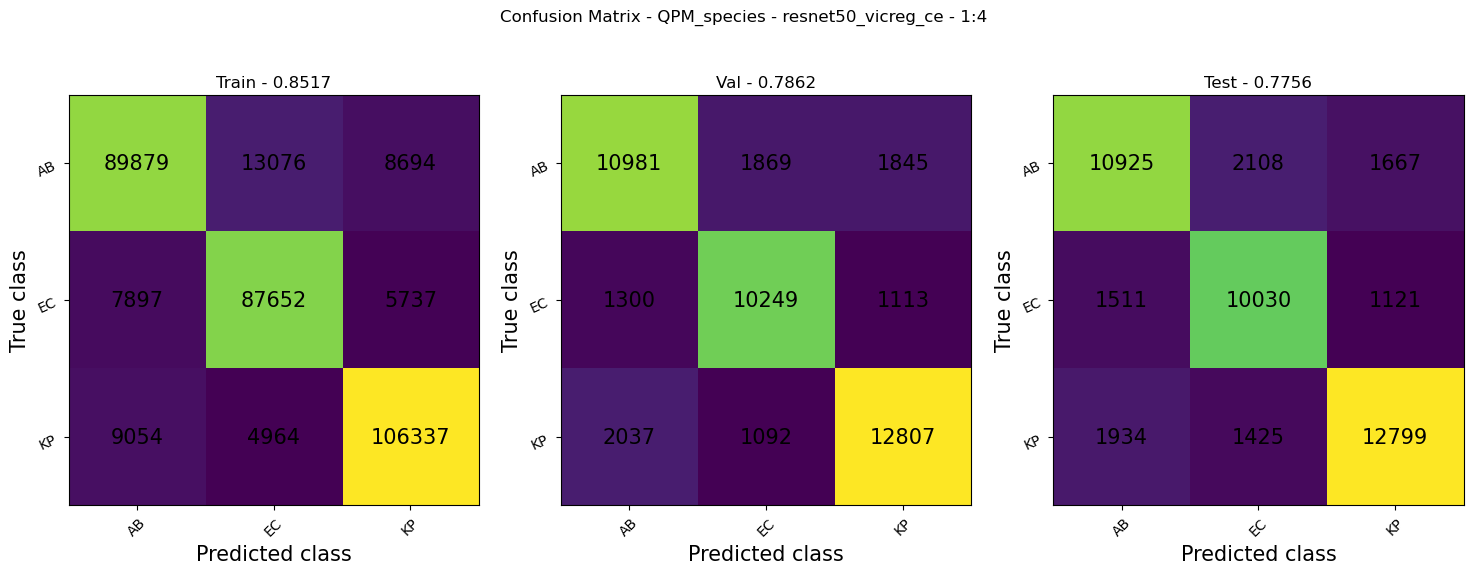

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(43520, 2) (5270, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(43520, 2) (5270, 2)


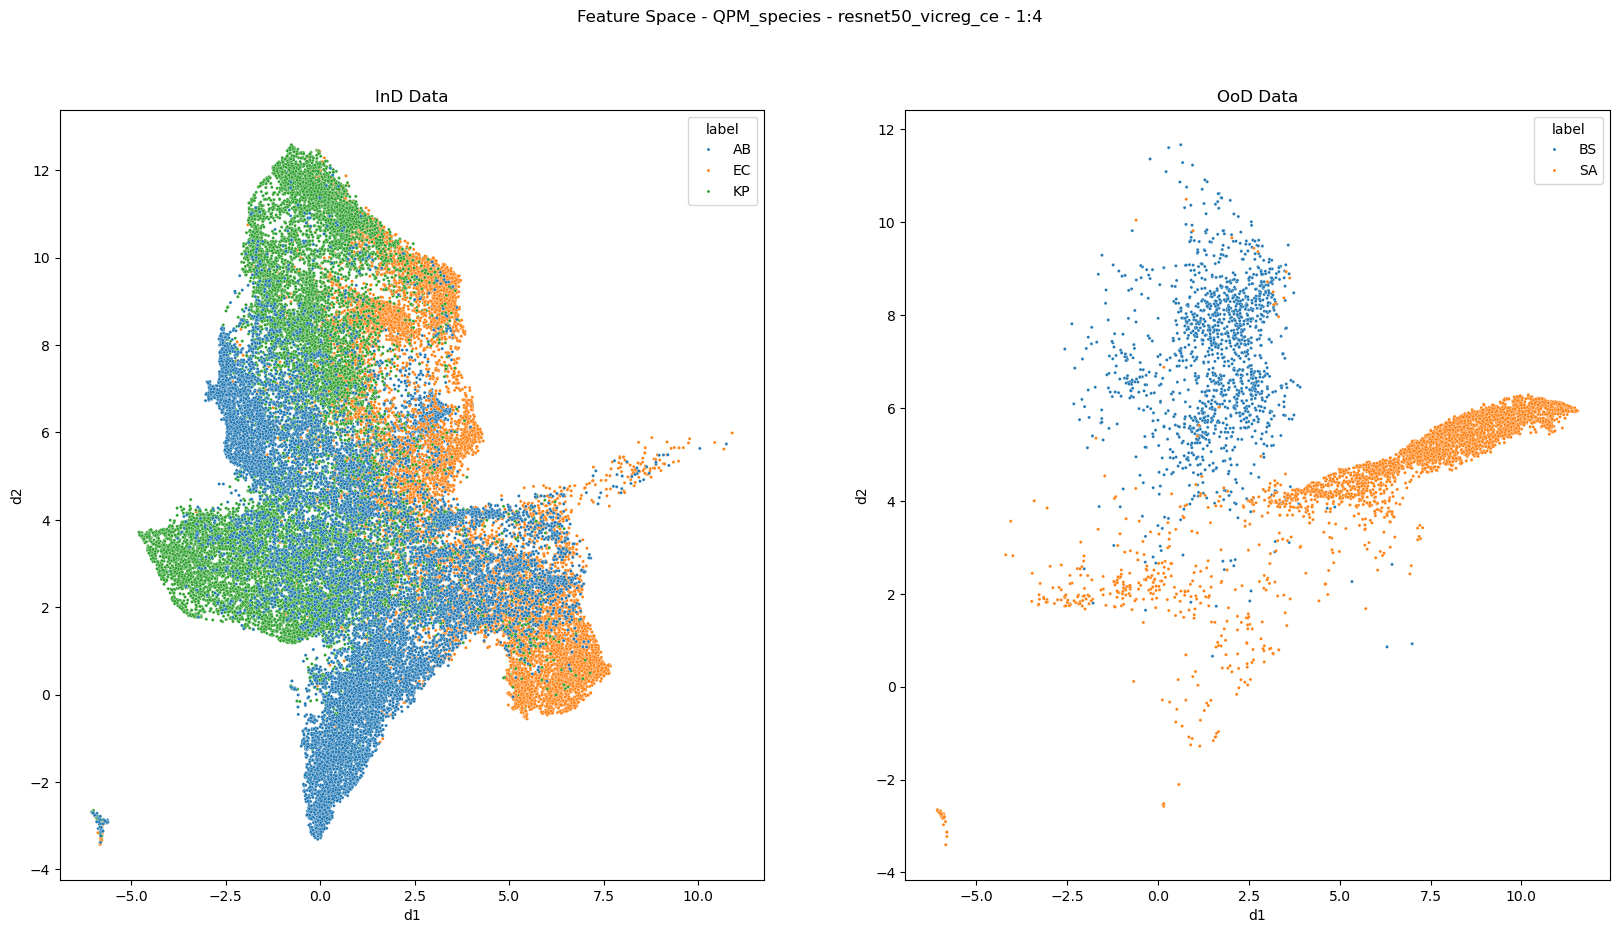

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

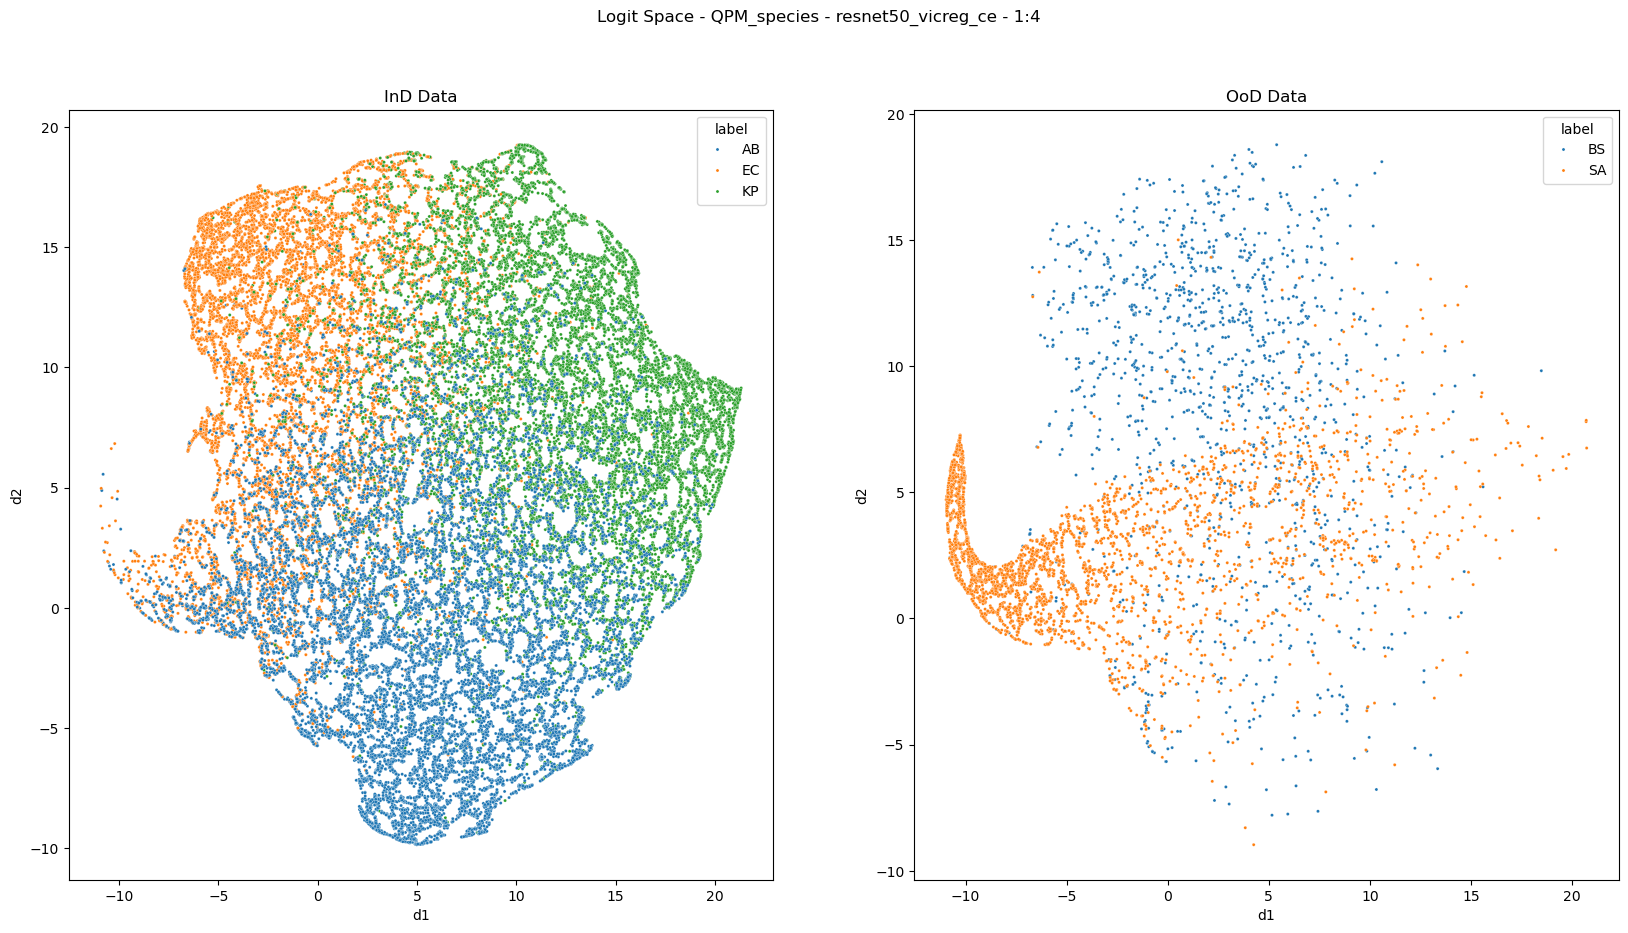

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

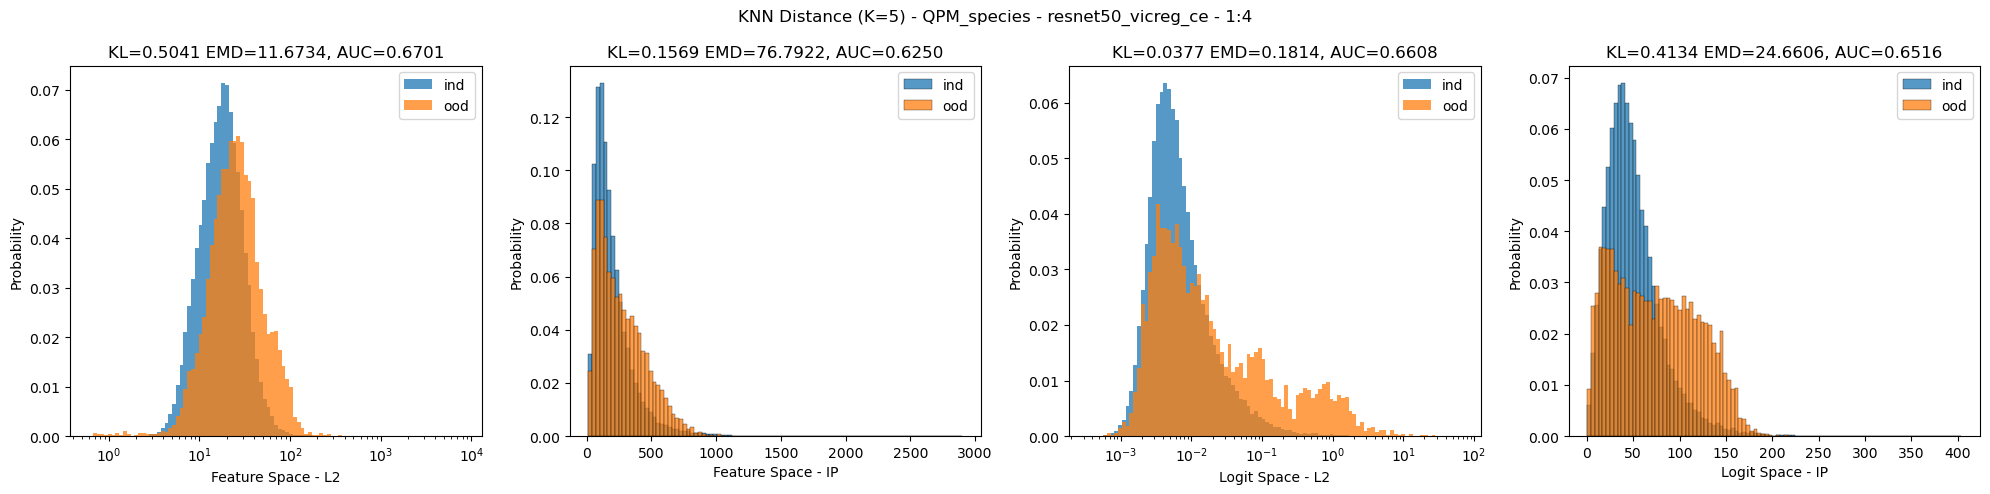

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

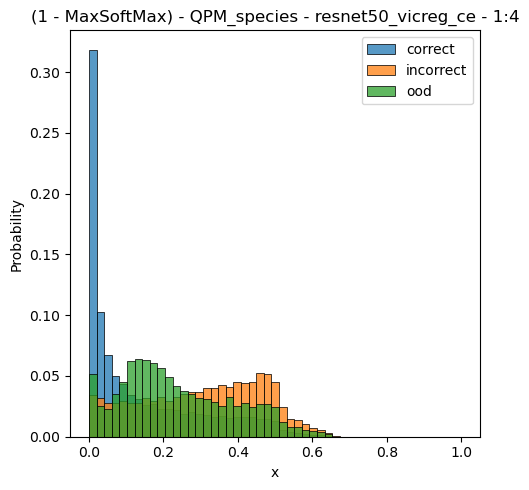

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()